# Collect data from all submissions

*Author: R.A. Collenteur, 16th of March 2023*

In [1]:
import os
import numpy as np
import pandas as pd

%matplotlib inline

import matplotlib.pyplot as plt
import pastas as ps


## 0. Teams overview



In [2]:
teams = pd.read_excel("../submissions/teams_overview.xlsx", header=[0,1], index_col=0)
teams = teams.drop("runwaygrey")  # Results do not seem correct, so not considered further
teams = teams.drop("regression")  # Opted out

teams

General Info                   General Info         Modelled              \
Team                                  Model    Type      USA Netherlands   
da_collective                        Pastas  lumped        1           1   
GEUS                                   LSTM      DL        1           1   
Janis                                    RF      ML        1           1   
LUHG                                 N-HiTS     NaN        1           1   
M2C_BRGM                        BC-MODWT-DL     NaN        1           1   
Mirkwood                                 RF      ML        1           1   
Selina_Yang                             SVR     NaN        0           1   
TUD                                    LSTM      DL        1           1   
RouhaniEtAl                             CNN     NaN        1           1   
gardenia                           Gardenia  Lumped        1           1   
HydroSight                       Hydrosight  Lumped        1           1   
MxNl           Ensemble of shallow learners     NaN        1           1   
TUV                             Transformer     NaN        1           1   
haidro                                 LSTM      DL        1           1   
uw                                      RNN     NaN        0           1   

General Info                            Development time                       \
Team          Germany Sweden_1 Sweden_2      Netherlands    Germany  Sweden_1   
da_collective       1        1        1         4.000000   4.000000  4.000000   
GEUS                1        1        1         2.000000   2.000000  2.000000   
Janis               1        1        1         0.500000   5.000000  0.500000   
LUHG                1        1        1         4.000000   4.000000  4.000000   
M2C_BRGM            1        1        1         5.000000   5.000000  5.000000   
Mirkwood            1        1        1         3.000000   3.000000  3.000000   
Selina_Yang         1        0        0         4.000000  30.000000       NaN   
TUD                 0        0        0         4.000000        NaN       NaN   
RouhaniEtAl         1        1        1         3.000000   3.000000  1.000000   
gardenia            1        1        1         0.500000   0.250000  0.500000   
HydroSight          1        1        1         0.083333   0.083333  0.083333   
MxNl                1        1        1         4.000000   4.000000  4.000000   
TUV                 1        1        1         2.000000   6.000000  3.000000   
haidro              1        1        1         2.000000   2.000000  2.000000   
uw                  1        0        0        72.000000  72.000000       NaN   

General Info                      Calibration time                        \
Team           Sweden_2       USA      Netherlands    Germany   Sweden_1   
da_collective  4.000000  4.000000         2.000000   2.000000   2.000000   
GEUS           2.000000  2.000000        15.000000  15.000000  15.000000   
Janis          0.500000  1.000000         0.095833   0.086111   0.013333   
LUHG           4.000000  4.000000         2.000000   2.000000   2.000000   
M2C_BRGM       5.000000  5.000000         0.500000   0.500000   0.500000   
Mirkwood       3.000000  3.000000         1.547222   1.341667   0.505556   
Selina_Yang         NaN       NaN         0.038889   0.046667        NaN   
TUD                 NaN  0.500000        48.000000        NaN        NaN   
RouhaniEtAl    1.000000  3.000000              NaN        NaN        NaN   
gardenia       0.500000  0.250000         0.011111   0.011111   0.011111   
HydroSight     0.083333  0.083333         2.000000   2.000000   2.000000   
MxNl           4.000000  4.000000         0.016667   0.016667   0.016667   
TUV            2.000000  2.000000         0.166667   0.166667   0.083333   
haidro         2.000000  2.000000         2.000000   2.000000   2.000000   
uw                  NaN       NaN         5.000000   5.000000        NaN   

General Info                        

## 1. Create multiIndex DataFrame

In [3]:
team_names = teams.index
wells = teams.loc[:, ("Modelled", slice(None))].columns.get_level_values(1)
#wells = wells.drop("Sweden_1")
ts = ["Simulated Head", "95% Lower Bound", "95% Upper Bound"]
mi = pd.MultiIndex.from_product([team_names, wells, ts])

tmin = "2000-01-01"
tmax = "2022-12-31"
index = pd.date_range(tmin, tmax, freq="D")
df = pd.DataFrame(index=index, columns=mi)
df.head()

da_collective                                                 \
Team                  USA                                    Netherlands   
           Simulated Head 95% Lower Bound 95% Upper Bound Simulated Head   
2000-01-01            NaN             NaN             NaN            NaN   
2000-01-02            NaN             NaN             NaN            NaN   
2000-01-03            NaN             NaN             NaN            NaN   
2000-01-04            NaN             NaN             NaN            NaN   
2000-01-05            NaN             NaN             NaN            NaN   

                                                                           \
Team                                              Germany                   
           95% Lower Bound 95% Upper Bound Simulated Head 95% Lower Bound   
2000-01-01             NaN             NaN            NaN             NaN   
2000-01-02             NaN             NaN            NaN             NaN   
2000-01-03             NaN             NaN            NaN             NaN   
2000-01-04             NaN             NaN            NaN             NaN   
2000-01-05             NaN             NaN            NaN             NaN   

                                           ...              uw                 \
Team                             Sweden_1  ...     Netherlands        Germany   
           95% Upper Bound Simulated Head  ... 95% Upper Bound Simulated Head   
2000-01-01             NaN            NaN  ...             NaN            NaN   
2000-01-02             NaN            NaN  ...             NaN            NaN   
2000-01-03             NaN            NaN  ...             NaN            NaN   
2000-01-04             NaN            NaN  ...             NaN            NaN   
2000-01-05             NaN            NaN  ...             NaN            NaN   

                                                                           \
Team                                             Sweden_1                   
           95% Lower Bound 95% Upper Bound Simulated Head 95% Lower Bound   
2000-01-01             NaN             NaN            NaN             NaN   
2000-01-02             NaN             NaN            NaN             NaN   
2000-01-03             NaN             NaN            NaN             NaN   
2000-01-04             NaN             NaN            NaN             NaN   
2000-01-05             NaN             NaN            NaN             NaN   

                                                                           
Team                             Sweden_2                                  
           95% Upper Bound Simulated Head 95% Lower Bound 95% Upper Bound  
2000-01-01             NaN            NaN             NaN             NaN  
2000-01-02             NaN            NaN             NaN             NaN  
2000-01-03             NaN            NaN             NaN             NaN  
2000-01-04             NaN            NaN             NaN             NaN  
2000-01-05             NaN            NaN             NaN             NaN  

[5 rows x 225 columns]

## 2. Collect the actual data

In [5]:
d = "../submissions"
folders = [o for o in os.listdir(d) if os.path.isdir(os.path.join(d,o))]
folders.remove(".ipynb_checkpoints")
folders.remove("team_runwaygrey")
folders.remove("team_regression")

for i, folder in enumerate(folders, start=1):
    team = folder.replace("team_", "")
    for well in wells:
        if bool(teams.loc[team, ("Modelled", well)]) == True:
            fname = "submission_form_{}.csv".format(well)
            ts = pd.read_csv(os.path.join(d, folder,fname), index_col=0, parse_dates=True, 
                             usecols=["Date", "Simulated Head", "95% Lower Bound", "95% Upper Bound"]).squeeze().loc[tmin:tmax]
            ts.index = ts.index.round("D")
            df.loc[ts.index, (team, well, slice(None))] = ts.values
            
df.to_csv("../data/all_results.csv")

## 3. Plot simulated heads for quick check

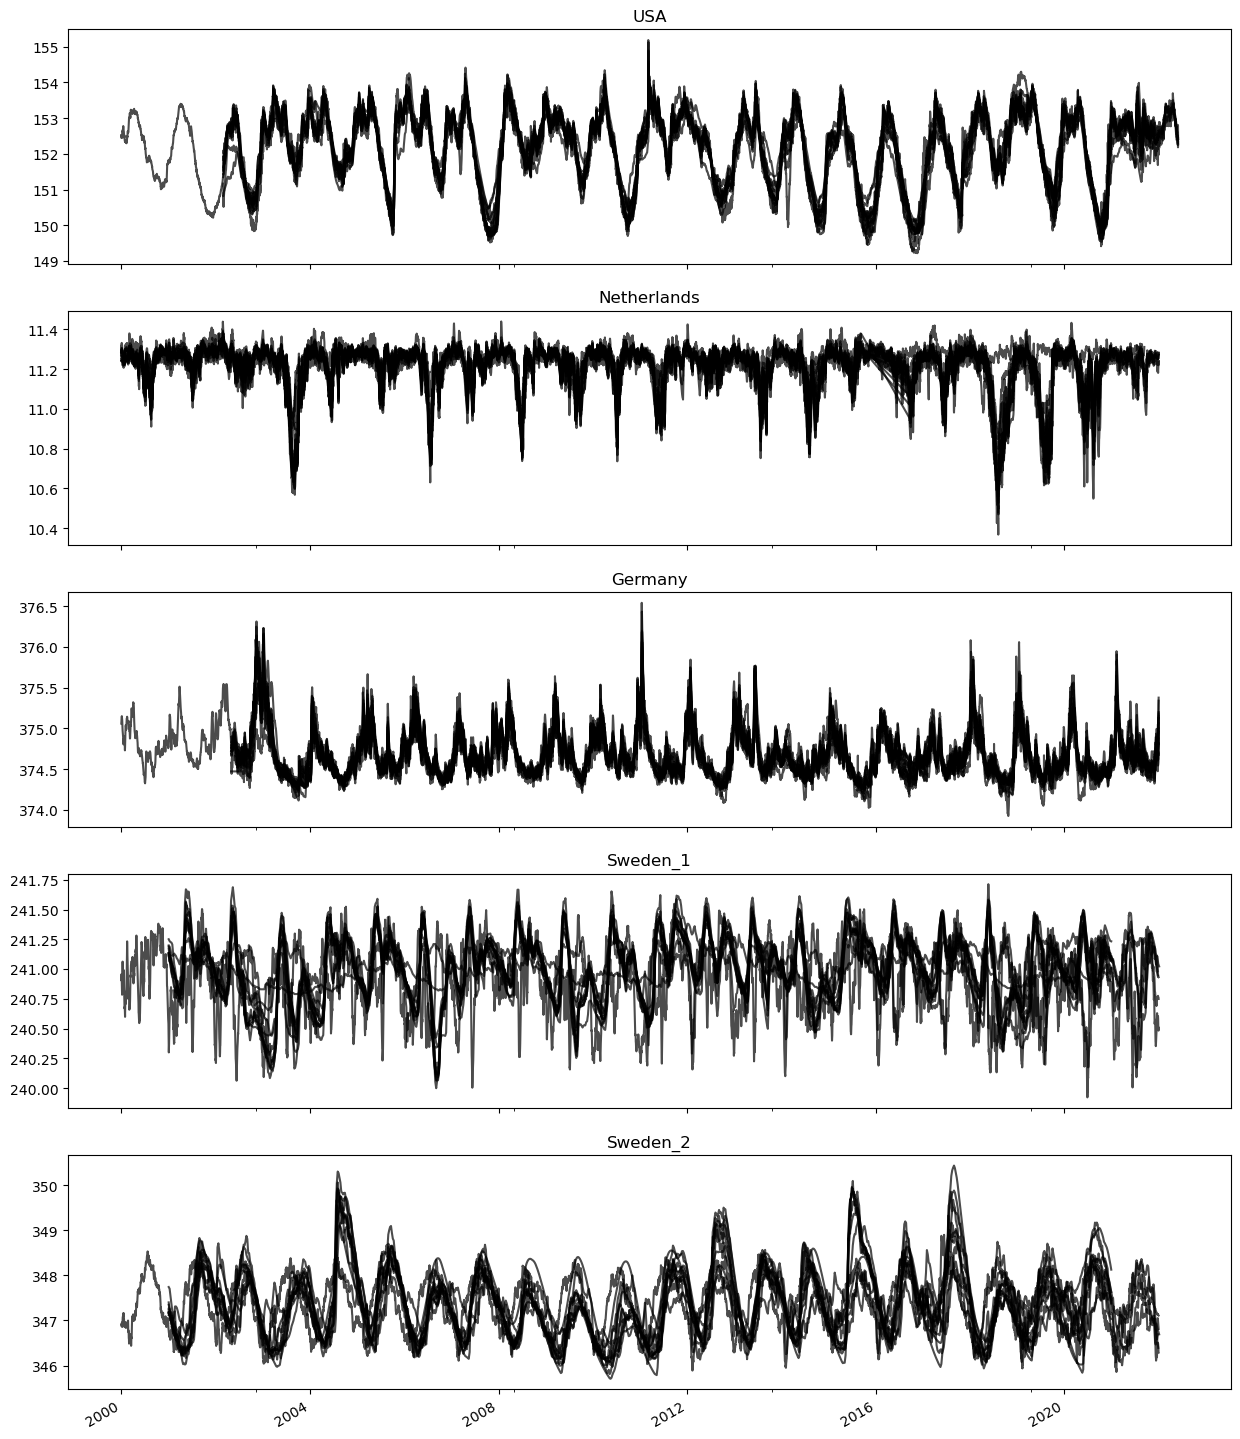

In [6]:
fig, axes = plt.subplots(5,1, figsize=(15,20), sharex=True)
axes = axes.flatten()

for i, well in enumerate(wells):
    
    for _, ts in df.loc[:, (slice(None), well, "Simulated Head")].astype(float).items():
        ts.dropna().plot(ax=axes[i], x_compat=True, legend=False, color="k", alpha=0.7)
        
    axes[i].set_title(well)

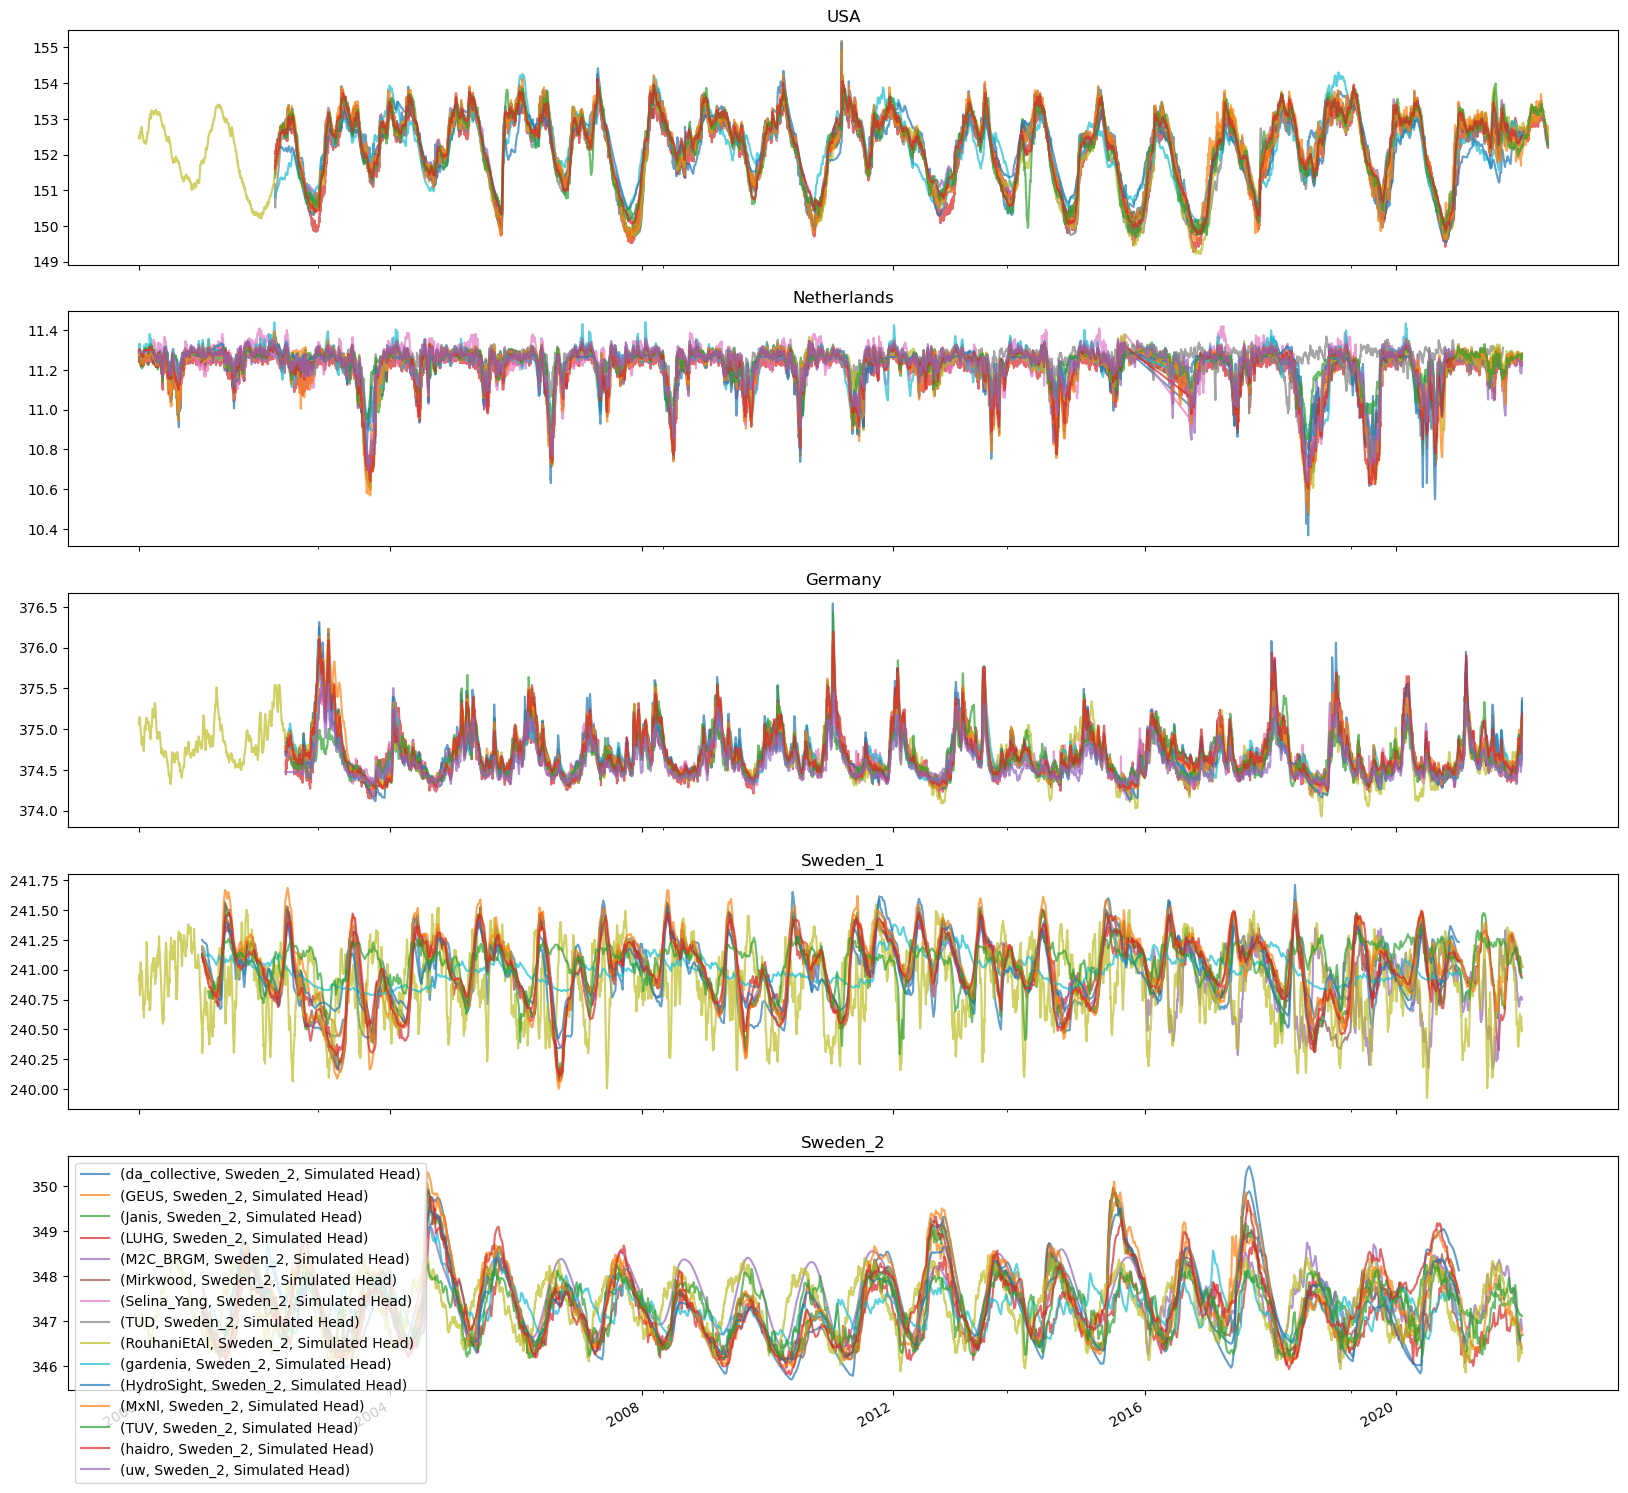

In [7]:
fig, axes = plt.subplots(5,1, figsize=(20,20), sharex=True)
axes = axes.flatten()

for i, well in enumerate(wells):
    
    for _, ts in df.loc[:, (slice(None), well, "Simulated Head")].astype(float).items():
        ts.dropna().plot(ax=axes[i], x_compat=True, legend=False, alpha=0.7)
        
    axes[i].set_title(well)
    
plt.legend()